<h1 align="center" style="font-variant: small-caps">How to build a genome-scale cell growth model</h1>
<h2 align="center">TUTORIAL 5 &mdash; Model size reduction</h2>
<h5 align="center">(<code>Version 13</code>, June 2025)</h5>

<div align="center" style="max-width:100px;display:block;margin:auto;">

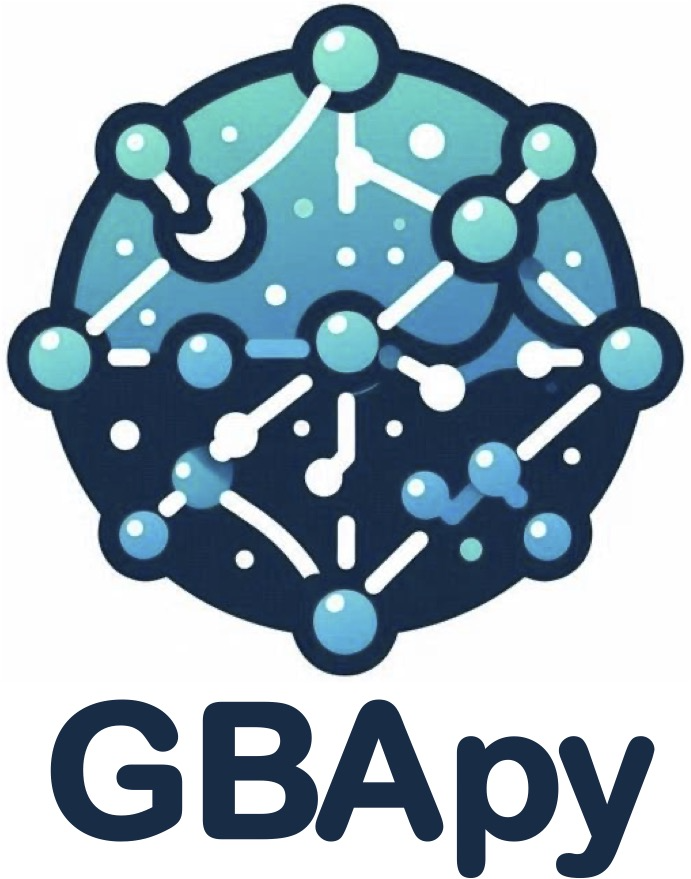

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the model builder](#load)
- [3. Create a function to automatically set up, build and test a CGM](#build)
- [4. Check the list of inactive reactions in the original model](#check_FBA_inactive)
- [5. Remove the list of FBA inactive reactions](#remove_FBA_inactive)
- [6. Remove inactive reactions in the CGM solution](#remove_CGM_inactive)
- [7. Backup the reduced model before building the final CGM](#backup)
- [8. Building the reduced CGM](#cgm)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

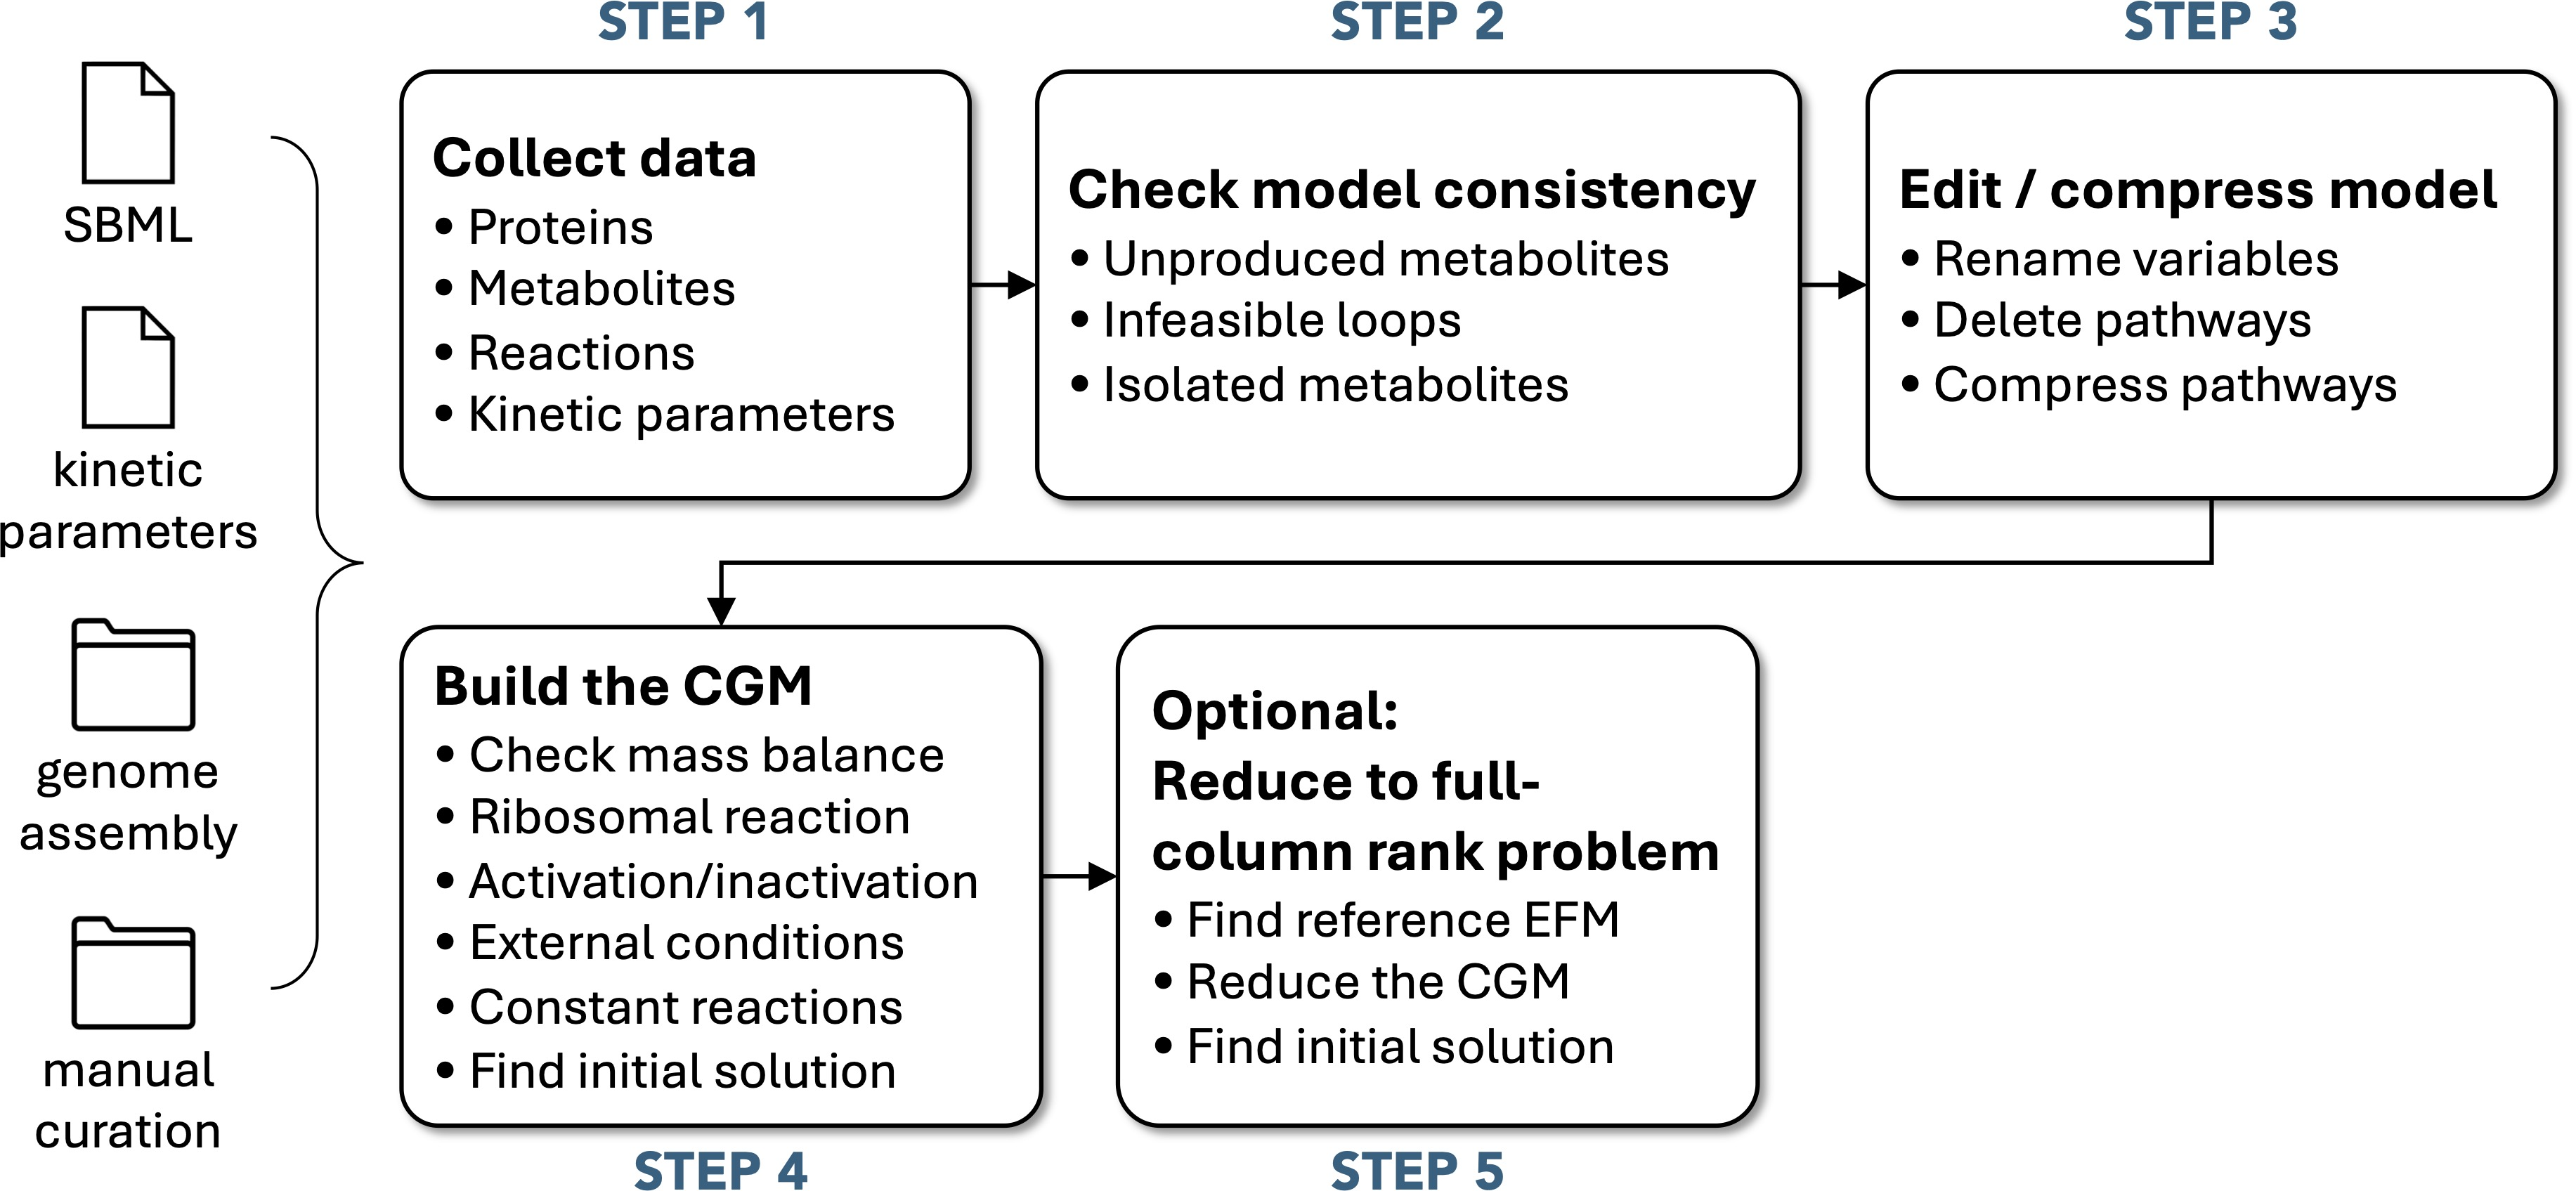

</div>

<div align="center">
<strong>At the beginning of each step of the tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In tutorial 4, we finalized a near complete version of the minimal cell and obtained what appears to be a correct initial solution. However, such a model cannot be easily optimized as its matrix is not full column rank (see below). Indeed, it has been shown that if the matrix is full column rank, the problem is proven to be convex, with a single optimal solution.

In this tutorial, we will reduce the model to obtain a full column rank and consistent CGM. We will do it in two steps:
- <strong>(1)</strong> Find an EFM and remove inactive reactions. Many approaches can be used to obtain an EFM (<em>e.g.</em> FBA, pFBA, Gecko, or RBA approaches). As a first approach, we will use a standard FBA optimization by reconstructing the original model conditions;
- <strong>(2)</strong> If the model is still not full column rank because of discrepancies between FBA and GBA versions, optimize the CGM to find an optimum, and remove remaining inactive reactions to reach a EFM into the CGM. At this stage, if an optimum is found which includes zero fluxes (as it is the case below), there is no guarantee that the optimum found is global.

# 2. Load the model builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a CGM builder from a backup |

</div>

The CGM builder is loaded from the backup created in tutorial 3.
We also re-load the original SBML model of a minimal cell.

In [1]:
import gba
import cobra
import numpy as np

builder    = gba.load_builder("backup/mmsyn_build_3.cgmbuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpaqpgeuxi.lp
Reading time = 0.00 seconds
: 156 rows, 376 columns, 1560 nonzeros


# 3. Create a function to automatically set up and build a GBA model <a id="build"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.check_model( test_structure )</code> | Test the consistency of the CGM build |
| <code>gba.Builder.adjust_masses( metabolites )</code> | Adjust masses from a list of positive or negative corrections |
| <code>gba.Builder.check_mass_balance( verbose )</code> | Check the mass balance of each reaction of the model |
| <code>gba.Builder.convert( ribosome_byproducts )</code> | Convert all model units to GBA units |
| <code>gba.Builder.build_CGM_variables()</code> | Build the CGM variables |
| <code>gba.Builder.clear_conditions()</code> | Delete all the external conditions of the CGM |
| <code>gba.Builder.add_condition( condition_id, rho, default_concentration, metabolites )</code> | Add an external condition to the CGM |
| <code>gba.Builder.add_activation_constant( metabolite_id, reaction_id, value )</code> | Add an activator metabolite to a reaction |
| <code>gba.Builder.add_constant_rhs( metabolite_id, value )</code> | Add a constant RHS term for the initial solution |
| <code>gba.Builder.clear_constant_reactions()</code> | Remove the list of constant reactions |
| <code>gba.Builder.enforce_directionality( flux_vector )</code> | Enforce the directionality of the CGM given a flux vector |
| <code>gba.Builder.export_model( path )</code> | Export the CGM in CSV format |
| <code>gba.read_csv_model( name, path )</code> | Load a CGM (class Model) from CSV files |
| <code>gba.Model.generate_LP_initial_solution( max_flux_fraction, rhs_factor, save_f0) </code> | Generate and test an initial solution to the CGM using a LP routine |

</div>

First, we create a function to automatically set up CGM properties (activators, constant fluxes, etc), build it, and find an initial solution.

This function will also print the column rank of the internal $M$ matrix, and if this matrix is full column rank.

In [2]:
def CGM_pipeline( builder, sbml_model,
                  max_flux_fraction, rhs_factor,
                  condition, rho, water_import,
                  ribosome_mass_kcat, ribosome_mass_km,
                  atpase_kcat,
                  modeled_proteome_fraction,
                  model_name ):
    builder.check_model(test_structure=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 1) Adjust metabolite masses               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    mass_adjustement                 = {}
    mass_adjustement["x_AA"]         = 17.007345999998506
    mass_adjustement["AA"]           = 17.007345999998506
    mass_adjustement["tRNA"]         = -94.58300315200177
    mass_adjustement["AAtRNA"]       = -94.58300315200177
    mass_adjustement["apoACP"]       = 1752.813
    mass_adjustement["ACP"]          = 1752.813
    mass_adjustement["ACP_R"]        = 1329.707
    mass_adjustement["dUTPase"]      = 2600.639
    mass_adjustement["PdhC"]         = 12940.79
    mass_adjustement["lpl_PdhC"]     = 12934.08
    mass_adjustement["acdhlpl_PdhC"] = 12934.08
    mass_adjustement["dhlpl_PdhC"]   = 12934.08
    mass_adjustement["Protein"]      = 8932.936
    mass_adjustement["x_5fthf"]      = 292.2431019999999
    mass_adjustement["5fthf"]        = 292.2431019999999
    mass_adjustement["lgltn"]        = 7.5569999999988795
    mass_adjustement["cdpdag"]       = 0.13765799800012246
    mass_adjustement["dnad"]         = 0.31494099599990477
    mass_adjustement["thfglu3"]      = 30.026026999999885
    mass_adjustement["fmettrna"]     = -667.2529067019968
    mass_adjustement["galfur12dgr"]  = -13.324124999999867
    gba.throw_message(gba.MessageType.Plain, "Adjusting masses")
    builder.adjust_masses(mass_adjustement)
    builder.check_mass_balance(verbose=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 2) Convert to GBA units                   #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.convert(ribosome_mass_kcat=ribosome_mass_kcat, ribosome_mass_km=ribosome_mass_km, modeled_proteome_fraction=modeled_proteome_fraction)
    builder.reactions["ATPase"].CGM_kcat[gba.ReactionDirection.Backward] = atpase_kcat
    #print(builder.reactions["ATPase"].summary())
    builder.build_CGM()

    #phi = 0.61
    #kcat = f / (p * phi * sat)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 3) Show the column rank of the matrix     #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    x1 = builder.CGM_column_rank
    x2 = builder.CGM_intM.shape[1]
    gba.throw_message(gba.MessageType.Plain, "Column rank {}/{} ( diff = {})".format(x1, x2, x2-x1))
    if builder.CGM_is_full_column_rank:
        gba.throw_message(gba.MessageType.Info, "Matrix is full column rank")
    gba.throw_message(gba.MessageType.Plain, "Dependent reactions:"+str(builder.CGM_dependent_reactions))
    gba.throw_message(gba.MessageType.Plain, "internal M shape:"+str(builder.CGM_intM.shape))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 3) Add conditions                         #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # (1) Load the medium composition from Thrornburg et al. (2022)
    f           = open("./data/Thornburg-et-al-2022/simulation_medium.csv", "r")
    l           = f.readline()
    l           = f.readline()
    metabolites = {}
    while l:
        l    = l.strip("\n").split(";")
        m_id = l[1]
        conc = float(l[4])
        if m_id in builder.metabolites:
            metabolites[m_id] = conc*0.001*builder.metabolites[m_id].mass
        l = f.readline()
    f.close()
    # (2) Complete the medium composition
    metabolites["x_h2o"] = 1000.0
    metabolites["x_h"]   = 1e-7
    # (3) Create external conditions with an external glucose gradient
    glucose_gradient = 10.0**np.arange(-5.9, 1.1, 0.1)
    index            = 1
    builder.clear_conditions()
    for i in range(len(glucose_gradient)):
        metabolites["x_glc__D"] = glucose_gradient[i]
        builder.add_condition(condition_id=index, rho=rho, default_concentration=1.0, metabolites=metabolites)
        index += 1
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 4) Activator metabolites and constant H2O #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if water_import is None:
        gba.throw_message(gba.MessageType.Plain, "Adding activators")
        DNA = rho*0.055
        RNA = rho*0.16274
        builder.add_activation_constant("DNA", "DNAP", DNA)
        builder.add_activation_constant("DNA", "RNAP", DNA)
        builder.add_activation_constant("DNA", "tRNAP", DNA)
        builder.add_activation_constant("RNA", "Ribosome", RNA)
        builder.add_constant_rhs("DNA", 0.055)
        builder.add_constant_rhs("RNA", 0.16274)
        #builder.add_constant_reaction("ATPase", 0.692546)
    else:
        gba.throw_message(gba.MessageType.Plain, "Adding activators")
        gba.throw_message(gba.MessageType.Plain, f"Adding constant H2O import: {water_import}")
        DNA = rho*(1-water_import)*0.055
        RNA = rho*(1-water_import)*0.16274
        builder.add_activation_constant("DNA", "DNAP", DNA)
        builder.add_activation_constant("DNA", "RNAP", DNA)
        builder.add_activation_constant("DNA", "tRNAP", DNA)
        builder.add_activation_constant("RNA", "Ribosome", RNA)
        builder.add_constant_rhs("DNA", 0.055*(1-water_import))
        builder.add_constant_rhs("RNA", 0.16274*(1-water_import))
        builder.clear_constant_reactions()
        builder.add_constant_reaction("H2Ot", water_import)
        #builder.add_constant_reaction("ATPase", 0.692546)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 6) Enforce directionality                 #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.enforce_directionality(builder.FBA_solution.fluxes)
    gba.throw_message(gba.MessageType.Plain, "Proteome fraction: "+str(builder.CGM_modeled_proteome_fraction))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 7) Create the CGM                         #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.summary()
    builder.export_model("./models", name=model_name)
    model = gba.read_csv_model(name=model_name, path="./models")
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 8) Find an initial solution               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    model.generate_LP_initial_solution(condition_id=condition, max_flux_fraction=max_flux_fraction, rhs_factor=rhs_factor, save_f0="./models") 

# 4. Check the list of inactive reactions in the reconstructed FBA solution <a id="check_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

To detect inactive reactions, we first reconstruct the FBA model, using the biomass function of the original JVCI-syn3A model, minus missing reactants removed from the current model build. To increase the realism of the solution, we enforce positive values for the production reactions we have added in previous tutorials.

We find 34 inactive reactions. When all these reactions will be removed, we will have reached a FBA elementary flux mode (EFM).

In [3]:
builder.reactions["H2Ot"].lb = 0.0

In [4]:
enforced_reactions = {"tRNAP": 1e-8,
                      "RNAP": 1e-8,
                      "ACP_transl": 1e-8,
                      "PdhC_transl": 1e-8,
                      "dUTPase_transl": 1e-8,
                      "H2Ot": 1e-8}
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")
builder.inactive_reactions

> 35 reactions to remove


['ACALDt',
 'ADEt2',
 'ADNabc',
 'CO2t',
 'CTPDP',
 'DCDPMP',
 'DCTPDP',
 'DCTPMP',
 'DURIK1',
 'DURIabc',
 'DUTPDP',
 'GAPDP',
 'GSNabc',
 'GUAt2',
 'NADK',
 'NAt3',
 'NTD1',
 'NTD5',
 'NTD6',
 'NTD8',
 'NTD9',
 'PDH_E1',
 'PDH_E2',
 'PGK2',
 'PPM',
 'PUNP1',
 'PUNP3',
 'PYK',
 'PYK3',
 'PYK9',
 'PYRt2r',
 'RNDR1',
 'RNDR2',
 'RNDR3',
 'RNDR4']

# 5. Remove the list of FBA inactive reactions <a id="remove_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.reset_conversion()</code> | Reset the conversion to GBA units |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

We will now remove all these reactions pathway by pathway.

In [5]:
builder.reset_conversion()

# Remove inactive transporters
reactions = ["ACALDt", "ADEt2", "ADNabc", "CO2t", "GUAt2", "NAt", "NAt3", "GSNabc", "PYRt2r"]
metabolites = ["x_acald", "x_ade", "x_adn", "adn", "x_co2", "x_gua", "x_na1", "na1", "x_gsn", "x_pyr"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove deoxyuridine metabolism
metabolites = ["x_duri", "duri"]
reactions   = ["DURIabc", "DURIK1", "NTD1"]#, "DCMPDA", "CTPSDUMP"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PUNP reactions
reactions = ["PUNP1", "PUNP3", "PPM"]
metabolites = ["r1p"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NTD reactions
reactions = ["NTD5", "NTD6", "NTD8", "NTD9"]
metabolites = ["gsn"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# RNDR reactions
reactions = ["RNDR1", "RNDR2", "RNDR3", "RNDR4"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PYK reactions
reactions = ["PYK", "PYK3", "PYK9"]
metabolites = ["dudp", "dutp"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PGK reactions
reactions = ["PGK2"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NADP metabolism
reactions = ["GAPDP", "NADK"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove acetaldehyde metabolism
reactions   = ["PDH_E1", "PDH_E2"]
metabolites = ["co2", "acdhlpl_PdhC"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Nucleotides metabolism
reactions = ["DUTPDP", "CTPDP", "DCDPMP", "DCTPDP", "DCTPMP"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)


In [6]:
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")
builder.inactive_reactions

> 0 reactions to remove


[]

In [7]:
#print(builder.FBA_solution.fluxes.to_string())

In [8]:
builder.reactions["H2Ot"].summary()

,H2Ot
Name,H2O transport via diffusion
Type,Transport
Stoichiometry,x_h2o <=> h2o
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,1.0
GPR,NONE
Proteins,1.0 spontaneous_protein
Forward kcat,10000000000.0
Backward kcat,10000000000.0


# 6. Remove inactive reactions in the CGM solution <a id="remove_CGM_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.reset_conversion()</code> | Reset the conversion to GBA units |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |

</div>

Finally, to ensure that a full column rank solution is reached with the CGM, we will optimize the model produced above using the C++ version of <strong>GBApy</strong> (<strong>GBAcpp</strong>, see https://github.com/charlesrocabert/gbacpp), which has been written to speed up the convergence to a growth rate optimum.
With this package, we can reach an optimum in 30 minutes to 1 hour on a laptop.

At the optimum, 6 reactions are inactive, and are removed below:

In [9]:
reactions   = ["GHMT2", "FMNAT", "RNA_degrad"]
metabolites = ["fad"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# 7. Backup the reduced model before building the final CGM model <a id="backup"></a>

[&#10148; Back to the table of contents](#table_of_contents)

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a CGM builder |

In [10]:
gba.backup_builder(builder, "mmsyn_build_5", "./backup")

In [11]:
# Load the proteomics data
proteomics   = {}
total_amount = 0.0
f            = open("data/manual_curation/MMSYN_proteomics.csv", "r")
l            = f.readline()
l            = f.readline()
while l:
    l    = l.strip("\n").split(";")
    p_id = l[0]
    w    = float(l[4])
    assert p_id not in proteomics
    assert p_id in builder.proteins
    if w > 0.0:
        proteomics[p_id] = w
        total_amount += w
    l = f.readline()
f.close()

# Parse reactions to calculate the fraction
modeled_proteins          = []
modeled_proteome_fraction = 0.0
for r in builder.reactions.values():
    for p_id in r.proteins:
        if p_id in proteomics and p_id not in modeled_proteins:
            modeled_proteins.append(p_id)
            modeled_proteome_fraction += proteomics[p_id]
        #elif p_id not in proteomics:
        #    gba.throw_message(gba.MessageType.Warning, "Protein {} not found in proteomics data".format(p_id))
modeled_proteome_fraction /= total_amount
print("Modeled proteome fraction: {:.2f}%".format(modeled_proteome_fraction * 100.0))
print("House-keeping fraction: {:.2f}%".format((1-modeled_proteome_fraction) * 100.0))

Modeled proteome fraction: 42.25%
House-keeping fraction: 57.75%


# 8. Building the reduced CGM <a id="cgm"></a>

[&#10148; Back to the table of contents](#table_of_contents)

Finally, we use our function `CGM_pipeline()` written above to produce the CGM. The model will be saved into `./tutorials/MMSYN_tutorials/models/.`, and can be later optimized with <strong>GBAcpp</strong>.

<strong>&#9888; Note that the final internal mass fraction matrix is <strong>not</strong> full column rank (rank 110 for 112 reactions). This is due to the enforced positive value for water transport. It is not a problem here, since all fluxes are positive in the optimal GBA solution.<strong>

In [12]:
#modeled_proteome_fraction = 0.3428434284342843
#modeled_proteome_fraction = 0.359899340270693
#modeled_proteome_fraction = 0.396680949466095
modeled_proteome_fraction = 1.0
builder                   = gba.load_builder("backup/mmsyn_build_5.cgmbuild")
CGM_pipeline(builder=builder, sbml_model=sbml_model, max_flux_fraction=40.0, rhs_factor=10.0,
             condition="70", rho=352, water_import=None,
             ribosome_mass_kcat=16, ribosome_mass_km=None,
             #ribosome_mass_kcat=1393.869, ribosome_mass_km=None,
             atpase_kcat=1.11,
             modeled_proteome_fraction=modeled_proteome_fraction,
             model_name="mmsyn_fcr_v1")

# ORIGINAL : 0.34239
# 0.54 : ribosome_mass_kcat=20, atpase_kcat=0.97
# 0.50 : ribosome_mass_kcat=20, atpase_kcat=1.15
# 0.5001 : ribosome_mass_kcat=15, atpase_kcat=1.1

Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpaa7_cfz_.lp
Reading time = 0.00 seconds
: 138 rows, 286 columns, 1216 nonzeros


❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


❯,Adjusting masses


❯ Info,Model build GBA_MMSYN is mass balanced.


❯,Column rank 112/115 ( diff = 3)


❯,"Dependent reactions:['TKT2', 'TPI']"


❯,"internal M shape:(112, 115)"


❯,Adding activators


❯,Proteome fraction: 1.0


CGM build GBA_MMSYN summary General 
 
 
 Category 
 Count 
 
 
 
 
 Known proteins 
 461 
 
 
 Modeled proteins 
 172 
 
 
 Metabolites 
 137 
 
 
 Reactions 
 115 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 114 
 83.21% 
 
 
 Macro-molecules 
 19 
 13.87% 
 
 
 DNA(s) 
 1 
 0.73% 
 
 
 RNA(s) 
 3 
 2.19% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 90 
 78.26% 
 
 
 Transport 
 25 
 21.74% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 65 
 56.52% 
 
 
 Backward 
 1 
 0.87% 
 
 
 Reversible 
 49 
 42.61%

❯ Info,Model is consistent with mu = 0.12218132663793335.
